In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_path = "../exp_model/v1"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype="auto", device_map="auto", trust_remote_code=True)


def chat(user_input):
    messages = [
        {"role": "system", "content": ''},
        {"role": "user", "content": user_input}
    ]

    input_ids = tokenizer.apply_chat_template(
        messages, add_generation_prompt=True, return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
        input_ids,
        max_new_tokens=1024,
        do_sample=True,
        temperature=0.2,
    )
    response = outputs[0][input_ids.shape[-1]:]
    return tokenizer.decode(response, skip_special_tokens=True)


# print(chat("你好"))
# torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [9]:
# from modelscope import GenerationConfig
# from modelscope import AutoModelForCausalLM, AutoTokenizer, snapshot_download
# import torch


# def chat(user_input):
#     model_path = "/home/zhangmin/.cache/modelscope/hub/TongyiFinance/Tongyi-Finance-14B-Chat"
#     tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
#     model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto", trust_remote_code=True).eval()
#     model.generation_config = GenerationConfig.from_pretrained(model_path, trust_remote_code=True)
#     response, history = model.chat(tokenizer, user_input, history=None)
#     return response


# print(chat("你好"))
# torch.cuda.empty_cache()

In [10]:
import pandas as pd

data = pd.read_parquet('processed_LLM_data_train_1_3_30.parquet')
# data = data.sample(frac=1).reset_index(drop=True)
data

,symbol,time,content,log_r
0,600031.SH,2018-10-10 09:00:00,现在是2018-10-10 09:00:00+08:00\n时间：2018-10-09 17...,-0.028921
1,600031.SH,2018-10-24 09:00:00,现在是2018-10-24 09:00:00+08:00\n时间：2018-10-09 17...,-0.023473
2,600031.SH,2018-12-07 09:00:00,现在是2018-12-07 09:00:00+08:00\n时间：2018-12-06 18...,-0.003693
3,600031.SH,2018-12-24 09:00:00,现在是2018-12-24 09:00:00+08:00\n时间：2018-12-06 18...,-0.008250
4,600031.SH,2018-12-24 09:00:00,现在是2018-12-24 09:00:00+08:00\n时间：2018-12-06 18...,-0.008250
...,...,...,...,...
6323,601668.SH,2023-03-31 09:00:00,现在是2023-03-31 09:00:00+08:00\n时间：2023-03-29 19...,0.015558
6324,601668.SH,2023-03-31 09:00:00,现在是2023-03-31 09:00:00+08:00\n时间：2023-03-30 18...,0.015558
6325,601668.SH,2023-03-31 09:00:00,现在是2023-03-31 09:00:00+08:00\n时间：2023-03-30 18...,0.015558
6326,601668.SH,2023-03-31 09:00:00,现在是2023-03-31 09:00:00+08:00\n时间：2023-03-30 18...,0.015558


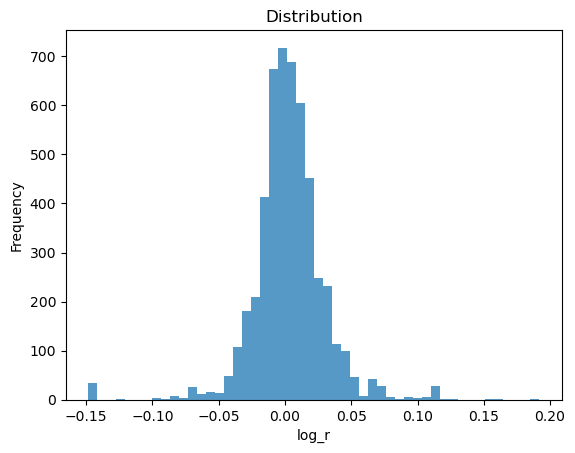

sigma: 0.028, mean: 0.003, variance: 0.001


In [11]:
import matplotlib.pyplot as plt

plt.hist(data['log_r'], bins=50, alpha=0.75)
plt.title('Distribution')
plt.xlabel('log_r')
plt.ylabel('Frequency')
plt.show()

sigma = round(data['log_r'].std(), 3)
mean = round(data['log_r'].mean(), 3)
variance = round(data['log_r'].var(), 3)

print(f'sigma: {sigma}, mean: {mean}, variance: {variance}')

In [12]:
data['label'] = pd.qcut(data['log_r'], 5, labels=False)
print(data[['log_r', 'label']].head())

      log_r  label
0 -0.028921      0
1 -0.023473      0
2 -0.003693      1
3 -0.008250      1
4 -0.008250      1


In [13]:
import json
from tqdm import tqdm

max_samples = 1500
total = 0
correct = 0
results = []
for i, row in tqdm(enumerate(data[:max_samples].iterrows())):
    try:
        stock_mapping = {
            "600031.SH": "三一重工",
            "600036.SH": "招商银行",
            "600050.SH": "中国联通",
            "600104.SH": "上汽集团",
            "600346.SH": "恒力石化",
            "600570.SH": "恒生电子",
            "600887.SH": "伊利股份",
            "601390.SH": "中国中铁",
            "603160.SH": "汇项科技",
            "601668.SH": "中国建筑"
        }
        label_mapping = {0: "极度负面", 1: "负面", 2: "中性", 3: "正面", 4: "极度正面"}
        label = label_mapping[row[1]['label']]
        stock = stock_mapping[row[1]['symbol']]
        prompt = f'请根据以下新闻文本，预测{stock}股票的对数收益率属于以下哪一类别 (极度负面/负面/中性/正面/极度正面)'
        # res = chat(prompt + row[1]['content'])
        # if label in res:
        #     correct += 1
        # else:
        #     print(f'Expected: {label}, Got: {res[:-1]}')

        def calculate_token_length(text):
            model_name = "/home/zhangmin/.cache/modelscope/hub/qwen/Qwen-7B-Chat"
            tokenizer = AutoTokenizer.from_pretrained(model_name,  trust_remote_code=True)
            tokens = tokenizer.encode(text, truncation=True)
            return len(tokens)

        token = calculate_token_length(row[1]['content'])

        if token >= 8192:
            print(f"Skipping row due to token size limitation: {token}")
            continue

        results.append({
            "prompt": prompt + row[1]['content'],
            # "response": res,
            "expected": label,
            # "correct": label in res,
        })
        total += 1
        # print(label)
        # print(f"-------Accuracy: {correct / total}----------")
        torch.cuda.empty_cache()
    except RuntimeError as e:
        if "The expanded size of the tensor" in str(e):
            print(f"Skipping row due to tensor size limitation: {e}")
        else:
            raise

with open('test_dataset/results.json', 'w') as f:
    json.dump(results, f, indent=4, ensure_ascii=False)

15it [00:07,  1.94it/s]

Skipping row due to token size limitation: 32768


16it [00:08,  1.84it/s]

Skipping row due to token size limitation: 32768


17it [00:08,  1.78it/s]

Skipping row due to token size limitation: 32768


21it [00:10,  1.93it/s]

Skipping row due to token size limitation: 32768


22it [00:11,  1.91it/s]

Skipping row due to token size limitation: 32768


23it [00:11,  1.89it/s]

Skipping row due to token size limitation: 32768


27it [00:13,  2.05it/s]

Skipping row due to token size limitation: 13805


28it [00:14,  2.03it/s]

Skipping row due to token size limitation: 15535


29it [00:14,  2.05it/s]

Skipping row due to token size limitation: 14244


32it [00:16,  2.06it/s]

Skipping row due to token size limitation: 8304


33it [00:16,  2.03it/s]

Skipping row due to token size limitation: 10401


34it [00:17,  1.98it/s]

Skipping row due to token size limitation: 11123


35it [00:17,  1.92it/s]

Skipping row due to token size limitation: 10269


36it [00:18,  1.96it/s]

Skipping row due to token size limitation: 24389


37it [00:18,  1.93it/s]

Skipping row due to token size limitation: 24002


38it [00:19,  1.95it/s]

Skipping row due to token size limitation: 17754


40it [00:20,  2.00it/s]

Skipping row due to token size limitation: 10284


41it [00:20,  2.02it/s]

Skipping row due to token size limitation: 10250


42it [00:21,  2.03it/s]

Skipping row due to token size limitation: 9509


48it [00:24,  2.09it/s]

Skipping row due to token size limitation: 20263


49it [00:24,  2.07it/s]

Skipping row due to token size limitation: 20239


63it [00:31,  2.09it/s]

Skipping row due to token size limitation: 9104


64it [00:31,  2.07it/s]

Skipping row due to token size limitation: 21809


66it [00:32,  2.09it/s]

Skipping row due to token size limitation: 8999


67it [00:33,  2.09it/s]

Skipping row due to token size limitation: 9728


68it [00:33,  2.09it/s]

Skipping row due to token size limitation: 8918


78it [00:38,  2.12it/s]

Skipping row due to token size limitation: 14248


79it [00:38,  2.11it/s]

Skipping row due to token size limitation: 14565


86it [00:42,  2.05it/s]

Skipping row due to token size limitation: 32768


87it [00:42,  1.99it/s]

Skipping row due to token size limitation: 32768


88it [00:43,  1.96it/s]

Skipping row due to token size limitation: 32768


89it [00:43,  2.00it/s]

Skipping row due to token size limitation: 19249


90it [00:44,  1.98it/s]

Skipping row due to token size limitation: 32768


91it [00:44,  2.00it/s]

Skipping row due to token size limitation: 29162


92it [00:45,  2.01it/s]

Skipping row due to token size limitation: 32768


93it [00:45,  2.02it/s]

Skipping row due to token size limitation: 17292


94it [00:46,  2.00it/s]

Skipping row due to token size limitation: 17550


95it [00:46,  2.00it/s]

Skipping row due to token size limitation: 13282


114it [00:55,  2.08it/s]

Skipping row due to token size limitation: 16728


115it [00:56,  2.08it/s]

Skipping row due to token size limitation: 20847


116it [00:56,  2.06it/s]

Skipping row due to token size limitation: 23320


117it [00:57,  2.06it/s]

Skipping row due to token size limitation: 15339


118it [00:57,  2.08it/s]

Skipping row due to token size limitation: 16028


119it [00:58,  2.06it/s]

Skipping row due to token size limitation: 15386


126it [01:01,  2.08it/s]

Skipping row due to token size limitation: 9441


134it [01:05,  2.01it/s]

Skipping row due to token size limitation: 32768


135it [01:06,  1.92it/s]

Skipping row due to token size limitation: 32768


136it [01:06,  1.86it/s]

Skipping row due to token size limitation: 32768


140it [01:08,  2.02it/s]

Skipping row due to token size limitation: 16466


141it [01:09,  2.03it/s]

Skipping row due to token size limitation: 20202


142it [01:09,  2.03it/s]

Skipping row due to token size limitation: 23137


143it [01:10,  1.90it/s]

Skipping row due to token size limitation: 32768


144it [01:10,  1.80it/s]

Skipping row due to token size limitation: 32768


145it [01:11,  1.72it/s]

Skipping row due to token size limitation: 32768


146it [01:11,  1.80it/s]

Skipping row due to token size limitation: 20876


158it [01:17,  2.08it/s]

Skipping row due to token size limitation: 32001


159it [01:18,  2.04it/s]

Skipping row due to token size limitation: 32768


160it [01:18,  2.02it/s]

Skipping row due to token size limitation: 32768


165it [01:21,  2.06it/s]

Skipping row due to token size limitation: 32768


166it [01:21,  2.05it/s]

Skipping row due to token size limitation: 32768


167it [01:22,  2.02it/s]

Skipping row due to token size limitation: 32768


168it [01:22,  2.03it/s]

Skipping row due to token size limitation: 14205


169it [01:23,  2.03it/s]

Skipping row due to token size limitation: 27463


170it [01:23,  2.05it/s]

Skipping row due to token size limitation: 21642


171it [01:24,  2.04it/s]

Skipping row due to token size limitation: 22354


191it [01:33,  2.09it/s]

Skipping row due to token size limitation: 13489


192it [01:34,  2.06it/s]

Skipping row due to token size limitation: 17899


193it [01:34,  2.02it/s]

Skipping row due to token size limitation: 29429


194it [01:35,  2.00it/s]

Skipping row due to token size limitation: 26293


195it [01:35,  2.01it/s]

Skipping row due to token size limitation: 24079


196it [01:36,  2.04it/s]

Skipping row due to token size limitation: 14121


197it [01:36,  2.06it/s]

Skipping row due to token size limitation: 11027


198it [01:37,  2.02it/s]

Skipping row due to token size limitation: 32768


199it [01:37,  1.98it/s]

Skipping row due to token size limitation: 32768


200it [01:38,  1.95it/s]

Skipping row due to token size limitation: 32768


201it [01:38,  1.96it/s]

Skipping row due to token size limitation: 32768


202it [01:39,  2.00it/s]

Skipping row due to token size limitation: 12190


203it [01:39,  2.04it/s]

Skipping row due to token size limitation: 12573


204it [01:40,  2.04it/s]

Skipping row due to token size limitation: 10664


216it [01:45,  2.10it/s]

Skipping row due to token size limitation: 13417


217it [01:46,  2.09it/s]

Skipping row due to token size limitation: 12590


218it [01:46,  2.09it/s]

Skipping row due to token size limitation: 11565


225it [01:50,  1.97it/s]

Skipping row due to token size limitation: 32768


226it [01:50,  1.89it/s]

Skipping row due to token size limitation: 32768


227it [01:51,  1.83it/s]

Skipping row due to token size limitation: 32768


230it [01:52,  2.00it/s]

Skipping row due to token size limitation: 18759


231it [01:53,  2.01it/s]

Skipping row due to token size limitation: 20211


232it [01:53,  2.02it/s]

Skipping row due to token size limitation: 20926


234it [01:54,  2.05it/s]

Skipping row due to token size limitation: 20037


235it [01:55,  2.05it/s]

Skipping row due to token size limitation: 20042


236it [01:55,  2.07it/s]

Skipping row due to token size limitation: 20045


243it [01:59,  2.09it/s]

Skipping row due to token size limitation: 20902


244it [01:59,  2.08it/s]

Skipping row due to token size limitation: 19375


245it [02:00,  2.07it/s]

Skipping row due to token size limitation: 19093


250it [02:02,  2.07it/s]

Skipping row due to token size limitation: 11445


251it [02:02,  2.05it/s]

Skipping row due to token size limitation: 11080


252it [02:03,  2.04it/s]

Skipping row due to token size limitation: 10670


257it [02:05,  2.09it/s]

Skipping row due to token size limitation: 11616


258it [02:06,  2.07it/s]

Skipping row due to token size limitation: 22391


259it [02:06,  2.07it/s]

Skipping row due to token size limitation: 22869


260it [02:07,  2.05it/s]

Skipping row due to token size limitation: 14356


262it [02:08,  2.06it/s]

Skipping row due to token size limitation: 24494


263it [02:08,  2.03it/s]

Skipping row due to token size limitation: 32768


264it [02:09,  2.01it/s]

Skipping row due to token size limitation: 32768


265it [02:09,  2.01it/s]

Skipping row due to token size limitation: 27375


279it [02:16,  2.10it/s]

Skipping row due to token size limitation: 8627


286it [02:19,  2.09it/s]

Skipping row due to token size limitation: 19721


287it [02:20,  2.07it/s]

Skipping row due to token size limitation: 21662


288it [02:20,  2.05it/s]

Skipping row due to token size limitation: 26000


289it [02:21,  2.08it/s]

Skipping row due to token size limitation: 8264


305it [02:28,  2.09it/s]

Skipping row due to token size limitation: 21101


306it [02:29,  2.06it/s]

Skipping row due to token size limitation: 20911


307it [02:29,  2.06it/s]

Skipping row due to token size limitation: 21175


313it [02:32,  2.10it/s]

Skipping row due to token size limitation: 8458


315it [02:33,  2.10it/s]

Skipping row due to token size limitation: 9554


318it [02:35,  1.94it/s]

Skipping row due to token size limitation: 32768


319it [02:35,  1.74it/s]

Skipping row due to token size limitation: 32768


320it [02:36,  1.59it/s]

Skipping row due to token size limitation: 32768


321it [02:37,  1.59it/s]

Skipping row due to token size limitation: 32768


322it [02:37,  1.65it/s]

Skipping row due to token size limitation: 32768


323it [02:38,  1.73it/s]

Skipping row due to token size limitation: 32768


324it [02:38,  1.82it/s]

Skipping row due to token size limitation: 23333


325it [02:39,  1.88it/s]

Skipping row due to token size limitation: 26202


326it [02:39,  1.92it/s]

Skipping row due to token size limitation: 23141


333it [02:43,  2.09it/s]

Skipping row due to token size limitation: 11545


334it [02:43,  2.09it/s]

Skipping row due to token size limitation: 14745


335it [02:44,  2.05it/s]

Skipping row due to token size limitation: 32768


336it [02:44,  2.03it/s]

Skipping row due to token size limitation: 32768


337it [02:45,  2.01it/s]

Skipping row due to token size limitation: 32768


338it [02:45,  2.03it/s]

Skipping row due to token size limitation: 14414


339it [02:46,  2.05it/s]

Skipping row due to token size limitation: 11347


341it [02:47,  2.04it/s]

Skipping row due to token size limitation: 32768


342it [02:47,  2.02it/s]

Skipping row due to token size limitation: 32768


343it [02:48,  2.02it/s]

Skipping row due to token size limitation: 32768


345it [02:48,  2.04it/s]

Skipping row due to token size limitation: 9673


346it [02:49,  2.06it/s]

Skipping row due to token size limitation: 17250


347it [02:49,  2.08it/s]

Skipping row due to token size limitation: 18167


348it [02:50,  2.06it/s]

Skipping row due to token size limitation: 18121


349it [02:50,  2.03it/s]

Skipping row due to token size limitation: 11669


359it [02:55,  2.10it/s]

Skipping row due to token size limitation: 8693


361it [02:56,  2.10it/s]

Skipping row due to token size limitation: 13198


362it [02:57,  2.08it/s]

Skipping row due to token size limitation: 9566


363it [02:57,  2.07it/s]

Skipping row due to token size limitation: 11358


369it [03:00,  2.08it/s]

Skipping row due to token size limitation: 13750


370it [03:00,  2.07it/s]

Skipping row due to token size limitation: 14148


371it [03:01,  2.07it/s]

Skipping row due to token size limitation: 17885


372it [03:01,  2.07it/s]

Skipping row due to token size limitation: 16260


373it [03:02,  2.08it/s]

Skipping row due to token size limitation: 15652


374it [03:02,  2.07it/s]

Skipping row due to token size limitation: 11008


386it [03:08,  2.09it/s]

Skipping row due to token size limitation: 8203


390it [03:10,  1.97it/s]

Skipping row due to token size limitation: 32768


391it [03:11,  1.89it/s]

Skipping row due to token size limitation: 32768


392it [03:11,  1.83it/s]

Skipping row due to token size limitation: 32768


408it [03:19,  2.06it/s]

Skipping row due to token size limitation: 12070


409it [03:19,  2.05it/s]

Skipping row due to token size limitation: 11836


410it [03:20,  2.06it/s]

Skipping row due to token size limitation: 11831


419it [03:24,  2.11it/s]

Skipping row due to token size limitation: 10146


420it [03:25,  2.07it/s]

Skipping row due to token size limitation: 27709


421it [03:25,  2.05it/s]

Skipping row due to token size limitation: 30970


422it [03:26,  2.03it/s]

Skipping row due to token size limitation: 28381


423it [03:26,  2.04it/s]

Skipping row due to token size limitation: 16272


424it [03:27,  2.04it/s]

Skipping row due to token size limitation: 11791


425it [03:27,  2.06it/s]

Skipping row due to token size limitation: 10646


429it [03:29,  2.09it/s]

Skipping row due to token size limitation: 13896


430it [03:30,  2.07it/s]

Skipping row due to token size limitation: 23950


431it [03:30,  2.05it/s]

Skipping row due to token size limitation: 24090


432it [03:30,  2.07it/s]

Skipping row due to token size limitation: 13750


436it [03:32,  2.08it/s]

Skipping row due to token size limitation: 26110


437it [03:33,  2.05it/s]

Skipping row due to token size limitation: 27742


438it [03:33,  2.02it/s]

Skipping row due to token size limitation: 29130


443it [03:36,  2.08it/s]

Skipping row due to token size limitation: 11562


444it [03:36,  2.09it/s]

Skipping row due to token size limitation: 11408


445it [03:37,  2.08it/s]

Skipping row due to token size limitation: 15216


446it [03:37,  2.09it/s]

Skipping row due to token size limitation: 8364


447it [03:38,  2.09it/s]

Skipping row due to token size limitation: 10934


449it [03:39,  2.06it/s]

Skipping row due to token size limitation: 32008


450it [03:39,  2.04it/s]

Skipping row due to token size limitation: 28440


451it [03:40,  2.02it/s]

Skipping row due to token size limitation: 32768


452it [03:40,  2.03it/s]

Skipping row due to token size limitation: 22237


453it [03:41,  2.04it/s]

Skipping row due to token size limitation: 22712


456it [03:42,  2.06it/s]

Skipping row due to token size limitation: 9810


457it [03:43,  2.06it/s]

Skipping row due to token size limitation: 8926


458it [03:43,  2.08it/s]

Skipping row due to token size limitation: 11145


459it [03:44,  2.09it/s]

Skipping row due to token size limitation: 11997


460it [03:44,  2.07it/s]

Skipping row due to token size limitation: 18689


461it [03:45,  2.04it/s]

Skipping row due to token size limitation: 32156


462it [03:45,  2.03it/s]

Skipping row due to token size limitation: 31086


471it [03:49,  2.10it/s]

Skipping row due to token size limitation: 10972


472it [03:50,  2.10it/s]

Skipping row due to token size limitation: 11650


473it [03:50,  2.09it/s]

Skipping row due to token size limitation: 11841


479it [03:53,  2.09it/s]

Skipping row due to token size limitation: 32768


480it [03:54,  1.89it/s]

Skipping row due to token size limitation: 32768


481it [03:54,  1.77it/s]

Skipping row due to token size limitation: 32768


482it [03:55,  1.71it/s]

Skipping row due to token size limitation: 32768


483it [03:56,  1.80it/s]

Skipping row due to token size limitation: 18565


484it [03:56,  1.84it/s]

Skipping row due to token size limitation: 32768


485it [03:57,  1.86it/s]

Skipping row due to token size limitation: 32768


486it [03:57,  1.85it/s]

Skipping row due to token size limitation: 32768


488it [03:58,  1.93it/s]

Skipping row due to token size limitation: 32768


489it [03:59,  1.94it/s]

Skipping row due to token size limitation: 32768


496it [04:02,  2.03it/s]

Skipping row due to token size limitation: 25188


497it [04:02,  2.02it/s]

Skipping row due to token size limitation: 31559


498it [04:03,  2.02it/s]

Skipping row due to token size limitation: 32768


499it [04:04,  1.98it/s]

Skipping row due to token size limitation: 32768


500it [04:04,  1.96it/s]

Skipping row due to token size limitation: 32768


508it [04:08,  2.03it/s]

Skipping row due to token size limitation: 32768


509it [04:08,  2.01it/s]

Skipping row due to token size limitation: 32768


518it [04:13,  2.11it/s]

Skipping row due to token size limitation: 15367


519it [04:13,  2.09it/s]

Skipping row due to token size limitation: 15062


520it [04:14,  2.06it/s]

Skipping row due to token size limitation: 32768


521it [04:14,  2.05it/s]

Skipping row due to token size limitation: 31496


522it [04:15,  2.03it/s]

Skipping row due to token size limitation: 32153


533it [04:20,  2.11it/s]

Skipping row due to token size limitation: 9538


558it [04:32,  2.11it/s]

Skipping row due to token size limitation: 17668


559it [04:32,  2.09it/s]

Skipping row due to token size limitation: 26526


560it [04:33,  2.07it/s]

Skipping row due to token size limitation: 26372


561it [04:33,  2.07it/s]

Skipping row due to token size limitation: 10557


568it [04:37,  2.08it/s]

Skipping row due to token size limitation: 9014


569it [04:37,  2.08it/s]

Skipping row due to token size limitation: 11940


570it [04:38,  2.06it/s]

Skipping row due to token size limitation: 32768


571it [04:38,  2.05it/s]

Skipping row due to token size limitation: 32768


572it [04:39,  2.02it/s]

Skipping row due to token size limitation: 32768


590it [04:47,  2.10it/s]

Skipping row due to token size limitation: 8796


591it [04:48,  2.09it/s]

Skipping row due to token size limitation: 8882


601it [04:53,  1.89it/s]

Skipping row due to token size limitation: 32768


602it [04:53,  1.79it/s]

Skipping row due to token size limitation: 32768


603it [04:54,  1.73it/s]

Skipping row due to token size limitation: 32768


604it [04:54,  1.82it/s]

Skipping row due to token size limitation: 12425


605it [04:55,  1.88it/s]

Skipping row due to token size limitation: 12068


632it [05:08,  2.05it/s]

Skipping row due to token size limitation: 24149


633it [05:09,  2.04it/s]

Skipping row due to token size limitation: 24152


634it [05:09,  2.01it/s]

Skipping row due to token size limitation: 24155


635it [05:10,  2.01it/s]

Skipping row due to token size limitation: 24158


636it [05:10,  2.01it/s]

Skipping row due to token size limitation: 24214


637it [05:10,  2.03it/s]

Skipping row due to token size limitation: 24256


674it [05:28,  2.08it/s]

Skipping row due to token size limitation: 12324


675it [05:29,  2.08it/s]

Skipping row due to token size limitation: 11574


676it [05:29,  2.07it/s]

Skipping row due to token size limitation: 14383


679it [05:31,  1.90it/s]

Skipping row due to token size limitation: 32768


680it [05:32,  1.61it/s]

Skipping row due to token size limitation: 32768


681it [05:32,  1.45it/s]

Skipping row due to token size limitation: 32768


682it [05:33,  1.41it/s]

Skipping row due to token size limitation: 32768


683it [05:34,  1.50it/s]

Skipping row due to token size limitation: 32768


686it [05:35,  1.83it/s]

Skipping row due to token size limitation: 20285


687it [05:36,  1.89it/s]

Skipping row due to token size limitation: 19627


688it [05:36,  1.92it/s]

Skipping row due to token size limitation: 20125


691it [05:38,  2.02it/s]

Skipping row due to token size limitation: 9062


694it [05:39,  1.95it/s]

Skipping row due to token size limitation: 32768


695it [05:40,  1.86it/s]

Skipping row due to token size limitation: 32768


696it [05:40,  1.81it/s]

Skipping row due to token size limitation: 32768


697it [05:41,  1.87it/s]

Skipping row due to token size limitation: 11651


698it [05:41,  1.93it/s]

Skipping row due to token size limitation: 9315


705it [05:45,  2.06it/s]

Skipping row due to token size limitation: 10756


706it [05:45,  2.06it/s]

Skipping row due to token size limitation: 11747


707it [05:46,  2.04it/s]

Skipping row due to token size limitation: 21469


708it [05:46,  2.04it/s]

Skipping row due to token size limitation: 12516


709it [05:47,  2.05it/s]

Skipping row due to token size limitation: 12703


715it [05:50,  2.02it/s]

Skipping row due to token size limitation: 19338


716it [05:50,  2.03it/s]

Skipping row due to token size limitation: 16920


717it [05:50,  2.04it/s]

Skipping row due to token size limitation: 14636


733it [05:58,  1.91it/s]

Skipping row due to token size limitation: 32768


734it [05:59,  1.78it/s]

Skipping row due to token size limitation: 32768


735it [06:00,  1.68it/s]

Skipping row due to token size limitation: 32768


736it [06:00,  1.77it/s]

Skipping row due to token size limitation: 12153


739it [06:02,  1.96it/s]

Skipping row due to token size limitation: 17924


740it [06:02,  2.00it/s]

Skipping row due to token size limitation: 18486


741it [06:02,  2.02it/s]

Skipping row due to token size limitation: 13400


750it [06:07,  2.10it/s]

Skipping row due to token size limitation: 24097


751it [06:07,  2.08it/s]

Skipping row due to token size limitation: 24218


783it [06:22,  1.88it/s]

Skipping row due to token size limitation: 32768


784it [06:23,  1.75it/s]

Skipping row due to token size limitation: 32768


785it [06:24,  1.67it/s]

Skipping row due to token size limitation: 32768


789it [06:26,  1.97it/s]

Skipping row due to token size limitation: 12086


790it [06:26,  2.00it/s]

Skipping row due to token size limitation: 13179


791it [06:27,  2.02it/s]

Skipping row due to token size limitation: 15986


795it [06:29,  2.01it/s]

Skipping row due to token size limitation: 32768


796it [06:29,  1.96it/s]

Skipping row due to token size limitation: 32768


797it [06:30,  1.78it/s]

Skipping row due to token size limitation: 32768


798it [06:31,  1.53it/s]

Skipping row due to token size limitation: 32768


799it [06:32,  1.39it/s]

Skipping row due to token size limitation: 32768


800it [06:32,  1.39it/s]

Skipping row due to token size limitation: 32768


809it [06:37,  2.06it/s]

Skipping row due to token size limitation: 8412


810it [06:37,  1.98it/s]

Skipping row due to token size limitation: 32768


811it [06:38,  1.90it/s]

Skipping row due to token size limitation: 32768


812it [06:38,  1.84it/s]

Skipping row due to token size limitation: 32768


825it [06:44,  2.11it/s]

Skipping row due to token size limitation: 9006


826it [06:45,  2.10it/s]

Skipping row due to token size limitation: 9567


839it [06:51,  1.99it/s]

Skipping row due to token size limitation: 32768


840it [06:52,  1.89it/s]

Skipping row due to token size limitation: 32768


847it [06:55,  2.10it/s]

Skipping row due to token size limitation: 9950


848it [06:56,  1.99it/s]

Skipping row due to token size limitation: 32768


849it [06:56,  1.94it/s]

Skipping row due to token size limitation: 32768


859it [07:01,  2.10it/s]

Skipping row due to token size limitation: 8838


860it [07:01,  2.11it/s]

Skipping row due to token size limitation: 8739


861it [07:02,  2.10it/s]

Skipping row due to token size limitation: 9672


862it [07:02,  2.10it/s]

Skipping row due to token size limitation: 18269


863it [07:03,  2.09it/s]

Skipping row due to token size limitation: 17950


864it [07:03,  2.09it/s]

Skipping row due to token size limitation: 16009


899it [07:20,  2.03it/s]

Skipping row due to token size limitation: 32768


900it [07:20,  1.98it/s]

Skipping row due to token size limitation: 32768


901it [07:21,  1.93it/s]

Skipping row due to token size limitation: 32768


902it [07:21,  1.97it/s]

Skipping row due to token size limitation: 16036


903it [07:22,  2.00it/s]

Skipping row due to token size limitation: 12002


905it [07:23,  1.89it/s]

Skipping row due to token size limitation: 32768


906it [07:24,  1.83it/s]

Skipping row due to token size limitation: 32768


907it [07:24,  1.77it/s]

Skipping row due to token size limitation: 32768


909it [07:25,  1.91it/s]

Skipping row due to token size limitation: 10883


917it [07:29,  2.08it/s]

Skipping row due to token size limitation: 9629


919it [07:30,  2.09it/s]

Skipping row due to token size limitation: 12322


920it [07:30,  2.09it/s]

Skipping row due to token size limitation: 11881


921it [07:31,  2.08it/s]

Skipping row due to token size limitation: 13883


950it [07:45,  2.10it/s]

Skipping row due to token size limitation: 15354


951it [07:45,  2.07it/s]

Skipping row due to token size limitation: 14081


952it [07:46,  2.08it/s]

Skipping row due to token size limitation: 9963


967it [07:53,  2.09it/s]

Skipping row due to token size limitation: 19469


968it [07:53,  2.07it/s]

Skipping row due to token size limitation: 18029


969it [07:54,  2.09it/s]

Skipping row due to token size limitation: 17645


979it [07:58,  2.03it/s]

Skipping row due to token size limitation: 32768


980it [07:59,  1.93it/s]

Skipping row due to token size limitation: 32768


981it [08:00,  1.76it/s]

Skipping row due to token size limitation: 32768


982it [08:00,  1.71it/s]

Skipping row due to token size limitation: 32768


983it [08:01,  1.69it/s]

Skipping row due to token size limitation: 32768


984it [08:01,  1.78it/s]

Skipping row due to token size limitation: 15705


985it [08:02,  1.86it/s]

Skipping row due to token size limitation: 18857


986it [08:02,  1.91it/s]

Skipping row due to token size limitation: 19233


987it [08:03,  1.94it/s]

Skipping row due to token size limitation: 9495


993it [08:06,  2.08it/s]

Skipping row due to token size limitation: 9080


994it [08:06,  2.09it/s]

Skipping row due to token size limitation: 10409


995it [08:07,  2.09it/s]

Skipping row due to token size limitation: 12803


996it [08:07,  2.10it/s]

Skipping row due to token size limitation: 8465


998it [08:08,  2.08it/s]

Skipping row due to token size limitation: 13964


999it [08:09,  2.07it/s]

Skipping row due to token size limitation: 18823


1000it [08:09,  2.05it/s]

Skipping row due to token size limitation: 18879


1004it [08:11,  2.07it/s]

Skipping row due to token size limitation: 18200


1005it [08:12,  2.08it/s]

Skipping row due to token size limitation: 21011


1006it [08:12,  2.06it/s]

Skipping row due to token size limitation: 21038


1023it [08:20,  1.98it/s]

Skipping row due to token size limitation: 32768


1024it [08:21,  1.88it/s]

Skipping row due to token size limitation: 32768


1025it [08:21,  1.81it/s]

Skipping row due to token size limitation: 32768


1035it [08:26,  2.08it/s]

Skipping row due to token size limitation: 13101


1036it [08:27,  2.07it/s]

Skipping row due to token size limitation: 13806


1037it [08:27,  2.06it/s]

Skipping row due to token size limitation: 19953


1039it [08:28,  2.08it/s]

Skipping row due to token size limitation: 12815


1040it [08:29,  2.08it/s]

Skipping row due to token size limitation: 11016


1041it [08:29,  2.09it/s]

Skipping row due to token size limitation: 11058


1042it [08:29,  2.09it/s]

Skipping row due to token size limitation: 13057


1043it [08:30,  2.08it/s]

Skipping row due to token size limitation: 8540


1044it [08:30,  2.09it/s]

Skipping row due to token size limitation: 9414


1047it [08:32,  1.98it/s]

Skipping row due to token size limitation: 32768


1048it [08:32,  1.93it/s]

Skipping row due to token size limitation: 32768


1049it [08:33,  1.88it/s]

Skipping row due to token size limitation: 32768


1071it [08:43,  2.09it/s]

Skipping row due to token size limitation: 16410


1072it [08:44,  2.09it/s]

Skipping row due to token size limitation: 12636


1073it [08:44,  2.08it/s]

Skipping row due to token size limitation: 10309


1083it [08:49,  2.12it/s]

Skipping row due to token size limitation: 11703


1084it [08:50,  2.12it/s]

Skipping row due to token size limitation: 11608


1085it [08:50,  2.10it/s]

Skipping row due to token size limitation: 11547


1091it [08:53,  2.10it/s]

Skipping row due to token size limitation: 15161


1092it [08:53,  2.06it/s]

Skipping row due to token size limitation: 31957


1093it [08:54,  2.05it/s]

Skipping row due to token size limitation: 32768


1094it [08:54,  2.05it/s]

Skipping row due to token size limitation: 21925


1099it [08:57,  2.10it/s]

Skipping row due to token size limitation: 9918


1100it [08:57,  2.10it/s]

Skipping row due to token size limitation: 11259


1101it [08:58,  2.11it/s]

Skipping row due to token size limitation: 11331


1106it [09:00,  2.08it/s]

Skipping row due to token size limitation: 9270


1107it [09:01,  2.06it/s]

Skipping row due to token size limitation: 9006


1108it [09:01,  2.09it/s]

Skipping row due to token size limitation: 8672


1120it [09:07,  2.12it/s]

Skipping row due to token size limitation: 9306


1122it [09:08,  2.12it/s]

Skipping row due to token size limitation: 9570


1123it [09:08,  2.11it/s]

Skipping row due to token size limitation: 9431


1124it [09:09,  2.09it/s]

Skipping row due to token size limitation: 13456


1125it [09:09,  2.09it/s]

Skipping row due to token size limitation: 11664


1129it [09:11,  2.11it/s]

Skipping row due to token size limitation: 9201


1135it [09:14,  2.13it/s]

Skipping row due to token size limitation: 12797


1136it [09:14,  2.11it/s]

Skipping row due to token size limitation: 12182


1137it [09:15,  2.05it/s]

Skipping row due to token size limitation: 32768


1138it [09:15,  1.88it/s]

Skipping row due to token size limitation: 32768


1139it [09:16,  1.76it/s]

Skipping row due to token size limitation: 32768


1140it [09:17,  1.75it/s]

Skipping row due to token size limitation: 32768


1168it [09:30,  2.12it/s]

Skipping row due to token size limitation: 9797


1169it [09:30,  2.11it/s]

Skipping row due to token size limitation: 9206


1170it [09:31,  2.11it/s]

Skipping row due to token size limitation: 8296


1171it [09:31,  2.09it/s]

Skipping row due to token size limitation: 16772


1172it [09:32,  2.08it/s]

Skipping row due to token size limitation: 16853


1173it [09:32,  2.08it/s]

Skipping row due to token size limitation: 15242


1180it [09:36,  2.05it/s]

Skipping row due to token size limitation: 32768


1181it [09:36,  2.04it/s]

Skipping row due to token size limitation: 32768


1182it [09:37,  2.00it/s]

Skipping row due to token size limitation: 32768


1183it [09:37,  2.02it/s]

Skipping row due to token size limitation: 19091


1184it [09:38,  2.02it/s]

Skipping row due to token size limitation: 21794


1211it [09:50,  2.11it/s]

Skipping row due to token size limitation: 10229


1212it [09:51,  2.08it/s]

Skipping row due to token size limitation: 22264


1213it [09:51,  2.05it/s]

Skipping row due to token size limitation: 32768


1214it [09:52,  2.03it/s]

Skipping row due to token size limitation: 32768


1215it [09:52,  2.01it/s]

Skipping row due to token size limitation: 32768


1216it [09:53,  2.02it/s]

Skipping row due to token size limitation: 13244


1217it [09:53,  2.05it/s]

Skipping row due to token size limitation: 8401


1218it [09:54,  2.05it/s]

Skipping row due to token size limitation: 12430


1220it [09:55,  2.08it/s]

Skipping row due to token size limitation: 13559


1221it [09:55,  1.99it/s]

Skipping row due to token size limitation: 32768


1222it [09:56,  1.91it/s]

Skipping row due to token size limitation: 32768


1223it [09:57,  1.87it/s]

Skipping row due to token size limitation: 32768


1227it [09:58,  2.05it/s]

Skipping row due to token size limitation: 8660


1229it [09:59,  2.07it/s]

Skipping row due to token size limitation: 16754


1230it [10:00,  2.08it/s]

Skipping row due to token size limitation: 14547


1231it [10:00,  2.05it/s]

Skipping row due to token size limitation: 32768


1232it [10:01,  2.03it/s]

Skipping row due to token size limitation: 32768


1233it [10:01,  2.04it/s]

Skipping row due to token size limitation: 32768


1235it [10:02,  2.08it/s]

Skipping row due to token size limitation: 8835


1236it [10:03,  1.97it/s]

Skipping row due to token size limitation: 32768


1237it [10:03,  1.90it/s]

Skipping row due to token size limitation: 32768


1238it [10:04,  1.85it/s]

Skipping row due to token size limitation: 32768


1239it [10:05,  1.86it/s]

Skipping row due to token size limitation: 17268


1240it [10:05,  1.93it/s]

Skipping row due to token size limitation: 8290


1246it [10:08,  2.05it/s]

Skipping row due to token size limitation: 26764


1247it [10:08,  2.02it/s]

Skipping row due to token size limitation: 26055


1248it [10:09,  2.02it/s]

Skipping row due to token size limitation: 25910


1251it [10:10,  2.03it/s]

Skipping row due to token size limitation: 25258


1252it [10:11,  2.03it/s]

Skipping row due to token size limitation: 25707


1253it [10:11,  2.04it/s]

Skipping row due to token size limitation: 27690


1256it [10:13,  2.02it/s]

Skipping row due to token size limitation: 22336


1257it [10:13,  2.01it/s]

Skipping row due to token size limitation: 22353


1258it [10:14,  2.03it/s]

Skipping row due to token size limitation: 18320


1262it [10:16,  2.05it/s]

Skipping row due to token size limitation: 32768


1263it [10:16,  2.03it/s]

Skipping row due to token size limitation: 32768


1264it [10:17,  2.04it/s]

Skipping row due to token size limitation: 32768


1268it [10:19,  2.06it/s]

Skipping row due to token size limitation: 16033


1269it [10:19,  2.05it/s]

Skipping row due to token size limitation: 16032


1270it [10:20,  2.04it/s]

Skipping row due to token size limitation: 18091


1271it [10:20,  2.03it/s]

Skipping row due to token size limitation: 18092


1272it [10:21,  2.04it/s]

Skipping row due to token size limitation: 18689


1273it [10:21,  2.05it/s]

Skipping row due to token size limitation: 22341


1275it [10:22,  2.06it/s]

Skipping row due to token size limitation: 8736


1295it [10:32,  1.99it/s]

Skipping row due to token size limitation: 8505


1296it [10:32,  2.02it/s]

Skipping row due to token size limitation: 9144


1297it [10:33,  2.04it/s]

Skipping row due to token size limitation: 10046


1308it [10:38,  2.10it/s]

Skipping row due to token size limitation: 10554


1309it [10:39,  2.09it/s]

Skipping row due to token size limitation: 10127


1310it [10:39,  2.08it/s]

Skipping row due to token size limitation: 10593


1322it [10:45,  1.95it/s]

Skipping row due to token size limitation: 32768


1323it [10:45,  1.86it/s]

Skipping row due to token size limitation: 32768


1324it [10:46,  1.80it/s]

Skipping row due to token size limitation: 32768


1326it [10:47,  1.91it/s]

Skipping row due to token size limitation: 32768


1327it [10:48,  1.91it/s]

Skipping row due to token size limitation: 32768


1328it [10:48,  1.92it/s]

Skipping row due to token size limitation: 32768


1334it [10:51,  2.07it/s]

Skipping row due to token size limitation: 11183


1335it [10:51,  2.07it/s]

Skipping row due to token size limitation: 11103


1336it [10:52,  2.08it/s]

Skipping row due to token size limitation: 11648


1339it [10:53,  2.07it/s]

Skipping row due to token size limitation: 10737


1340it [10:54,  2.07it/s]

Skipping row due to token size limitation: 11164


1341it [10:54,  2.07it/s]

Skipping row due to token size limitation: 9689


1343it [10:55,  2.06it/s]

Skipping row due to token size limitation: 25484


1344it [10:56,  2.04it/s]

Skipping row due to token size limitation: 32768


1345it [10:56,  2.04it/s]

Skipping row due to token size limitation: 32768


1346it [10:57,  2.04it/s]

Skipping row due to token size limitation: 9914


1354it [11:01,  2.10it/s]

Skipping row due to token size limitation: 8521


1358it [11:03,  2.05it/s]

Skipping row due to token size limitation: 8806


1370it [11:08,  2.02it/s]

Skipping row due to token size limitation: 32768


1371it [11:09,  2.01it/s]

Skipping row due to token size limitation: 32768


1372it [11:09,  1.96it/s]

Skipping row due to token size limitation: 32768


1373it [11:10,  1.96it/s]